# Strain mapping with all calibrations
___

## 4B: Measure lattice strain - Calculate strain

Calculate the in-plane elements of the [infinitesimal strain matrix](https://en.wikipedia.org/wiki/Infinitesimal_strain_theory).  The calculation is performed by first fitting the lattice vectors at each scan position to the detected Bragg peaks, weighting the importance of each Bragg peak by its intensity.  The variation of the lattice vectors relative to a reference lattice at each scan position is then used used to find the strain.  The reference lattice can be some selected region of the data itself, or optionally can be input separately, e.g. using another scan of some unstrained sample.  Optionally if the detector pixel size has been calibrated, absolute-scale lattice parameter maps can be generated as well.
___

- Inputs:
  - Bragg peaks, corrected, for the experimental sample
  - lattice vectors, initial guess
  - RQ offset, RQ flip
  - Q pixel size (optional)
  - lattice vectors, reference (optional)
- Outputs:
  - strain maps (relative scale)
  - lattice parameter maps (absolute scale) (optional)

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.ndimage.filters import gaussian_filter
from numpy.linalg import lstsq
from scipy.ndimage.morphology import binary_closing

from py4DSTEM.file.datastructure import RealSlice, PointList
from py4DSTEM.file.io import FileBrowser, read, append

from py4DSTEM.process.latticevectors import index_bragg_directions, fit_lattice_vectors, fit_lattice_vectors_all_DPs
from py4DSTEM.process.latticevectors import add_indices_to_braggpeaks, get_strain_from_reference_uv, get_rotated_strain_map
from py4DSTEM.process.utils import get_maxima_2D
from py4DSTEM.process.calibration import RQ_axes

In [2]:
# Examine contents of processing_sampledata.h5

fp_processing = "/media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/LFP100_P1/processing_sampledata.h5"
browser = py4DSTEM.file.io.FileBrowser(fp_processing)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    braggvectormap_calibrationdata_shiftcorrectedDiffractionSlice    
   1    braggvectormap_corrected_calibrationdataDiffractionSlice    
   2    braggvectormap_corrected_experiment DiffractionSlice    
   3    braggvectormap_experiment_shiftcorrectedDiffractionSlice    
   4    braggvectormap_uncorrected_calibrationdataDiffractionSlice    
   5    braggvectormap_uncorrected_experimentDiffractionSlice    
   6    probe                               DiffractionSlice    
   7    diffractionshifts_calibrationdata   RealSlice           
   8    diffractionshifts_experiment        RealSlice           
   9    virtual_image                       RealSlice           
   10   Qpixel_calibration                  PointList           
   11   RQ_rotational_offset_degrees        PointList           
   12   elliptical_distortion               PointList           
   13   lattice_vectors                     PointList           
 

In [3]:
# Load data

braggpeaks = browser.get_dataobject('braggpeaks_corrected_experiment')
lattice_vectors = browser.get_dataobject('lattice_vectors')
braggvectormap = browser.get_dataobject('braggvectormap_corrected_experiment').data
inv_A_per_pixel = browser.get_dataobject('Qpixel_calibration').data['inv_A_per_pixel'][0]
RQ_offset_angle = browser.get_dataobject('RQ_rotational_offset_degrees').data[0][0]
browser.close()

R_Nx,R_Ny = braggpeaks.shape
Q_Nx,Q_Ny = braggvectormap.shape

### Index Bragg directions

In [4]:
# Get beta, the lattice vector matrix
# Note that for the initial pass

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap,2)),braggvectormap.shape)

ux = lattice_vectors.data['qx'][0]
uy = lattice_vectors.data['qy'][0]
vx = lattice_vectors.data['qx'][1]
vy = lattice_vectors.data['qy'][1]

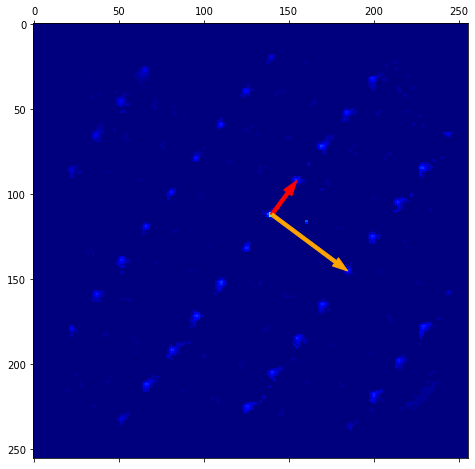

In [5]:
# Show deconvolution and lattice vectors

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(braggvectormap**0.25,cmap='jet')
ax.arrow(y0,x0,uy,ux, color='red',width=2,length_includes_head=True)
ax.arrow(y0,x0,vy,vx, color='orange',width=2,length_includes_head=True)
plt.show()

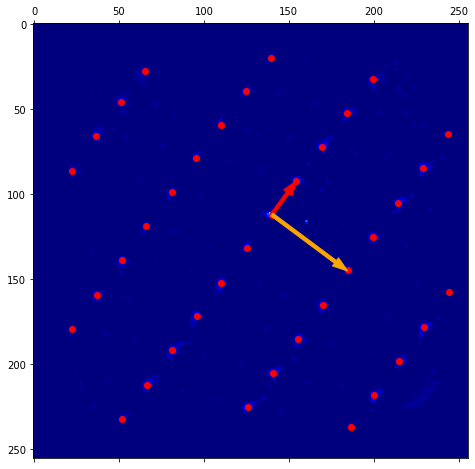

In [6]:
# Find Bragg vector map peak positions

sigma = 2
minSpacing = 22
minRelativeIntensity = 0.005
relativeToPeak = 1
maxNumPeaks = 40

power = 0.25

maxima_x,maxima_y,_ = get_maxima_2D(braggvectormap, sigma=sigma, minSpacing=minSpacing, minRelativeIntensity=minRelativeIntensity,
                                    relativeToPeak=relativeToPeak, maxNumPeaks=maxNumPeaks)

# Show
fig,ax=plt.subplots(figsize=(8,8))
ax.matshow(braggvectormap**power,cmap='jet')
ax.scatter(maxima_y,maxima_x,color='r')
ax.arrow(y0,x0,uy,ux, color='red',width=2,length_includes_head=True)
ax.arrow(y0,x0,vy,vx, color='orange',width=2,length_includes_head=True)
plt.show()

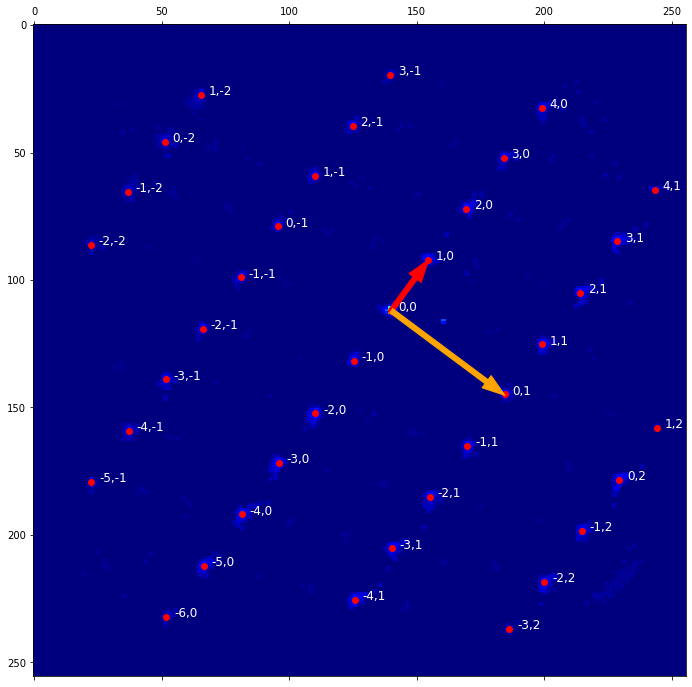

In [7]:
# Calculate indices

textoffset=3

# Get indices
h,k,bragg_directions = index_bragg_directions(x0,y0,ux,uy,vx,vy,maxima_x,maxima_y)

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap**.25,cmap='jet')
ax.scatter(bragg_directions.data['qy'],bragg_directions.data['qx'],color='r')
ax.arrow(y0,x0,uy,ux, color='red',width=2,length_includes_head=True)
ax.arrow(y0,x0,vy,vx, color='orange',width=2,length_includes_head=True)
for i in range(bragg_directions.length):
    ax.text(bragg_directions.data['qy'][i]+textoffset,bragg_directions.data['qx'][i],
            '{},{}'.format(bragg_directions.data['h'][i],bragg_directions.data['k'][i]),
            color='w',size=12)
plt.show()

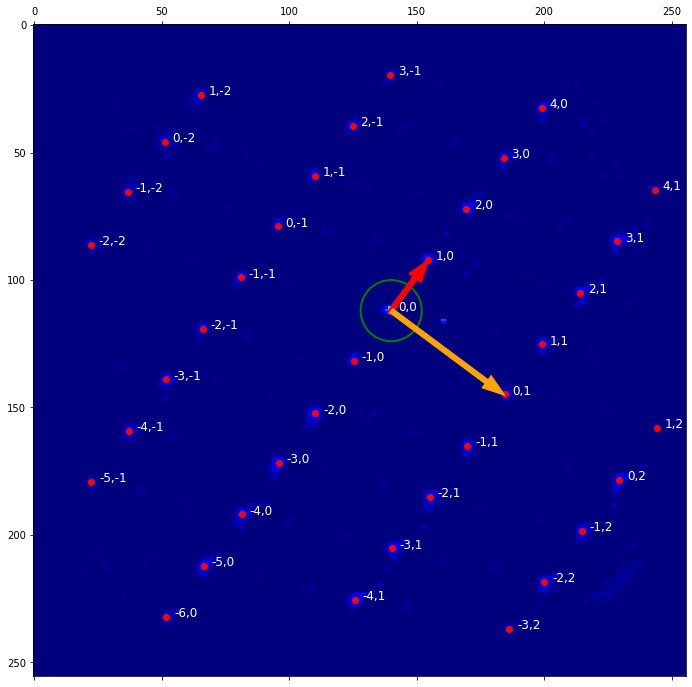

In [8]:
# Select maxPeakSpacing

maxPeakSpacing = 12

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap**.25,cmap='jet')
ax.scatter(bragg_directions.data['qy'],bragg_directions.data['qx'],color='r')
ax.arrow(y0,x0,uy,ux, color='red',width=2,length_includes_head=True)
ax.arrow(y0,x0,vy,vx, color='orange',width=2,length_includes_head=True)
for i in range(bragg_directions.length):
    ax.text(bragg_directions.data['qy'][i]+textoffset,bragg_directions.data['qx'][i],
            '{},{}'.format(bragg_directions.data['h'][i],bragg_directions.data['k'][i]),
            color='w',size=12)
circ = Circle((y0,x0),maxPeakSpacing,fill=False,color='g',linewidth=2)
ax.add_patch(circ)
plt.show()

In [9]:
# Add indices to the braggpeaks PointListArray

braggpeaks_indexed = add_indices_to_braggpeaks(braggpeaks,
                                               bragg_directions,
                                               maxPeakSpacing=maxPeakSpacing)

### Fit lattice vectors

In [10]:
# Perform fit

maxPeakSpacing = 20
minNumPeaks = 6
x0,y0 = np.unravel_index(np.argmax(braggvectormap),braggvectormap.shape)

uv_map = fit_lattice_vectors_all_DPs(braggpeaks, bragg_directions, x0, y0, maxPeakSpacing, minNumPeaks)

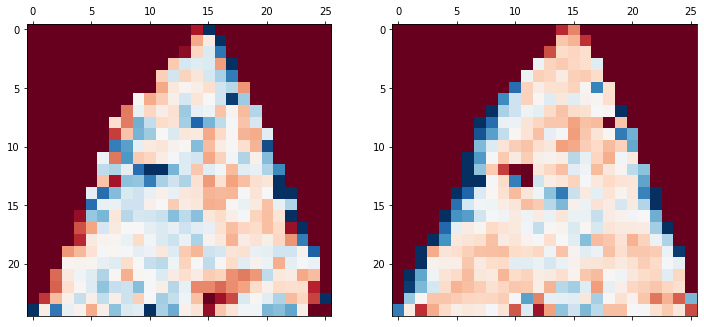

In [11]:
# Plot (uncalibrated) lattice vector lengths

n_stds = 2

u_lengths = np.sqrt(uv_map.slices['ux']**2 + uv_map.slices['uy']**2)
v_lengths = np.sqrt(uv_map.slices['vx']**2 + uv_map.slices['vy']**2)
u_length_ave, u_length_std = np.average(u_lengths[uv_map.slices['mask'].astype(bool)]), np.std(u_lengths[uv_map.slices['mask'].astype(bool)])
v_length_ave, v_length_std = np.average(v_lengths[uv_map.slices['mask'].astype(bool)]), np.std(v_lengths[uv_map.slices['mask'].astype(bool)])

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,12))
ax1.matshow(u_lengths, vmin=u_length_ave-n_stds*u_length_std, vmax=u_length_ave+n_stds*u_length_std, cmap="RdBu")
ax2.matshow(v_lengths, vmin=v_length_ave-n_stds*v_length_std, vmax=v_length_ave+n_stds*v_length_std, cmap="RdBu")
plt.show()

### Get reference lattice

The strain map is defined with respect to a reference lattice.  In this case, we'll construct the reference lattice as follows:
- determine the average direction of the experimental lattice vectors
- construct reference basis vectors which are oriented according to this direction, and with lengths and spanned angle given by known literature values

A reference lattice can alternatively be defined from a reference region in the data, or in some other dataset, using 

```
ux,uy,vx,vy = py4DSTEM.process.latticevectors.get_reference_uv(mask, uv_map)
```

which finds the median lattice vectors in `uv_map` from scan positions where `mask` is `True`.

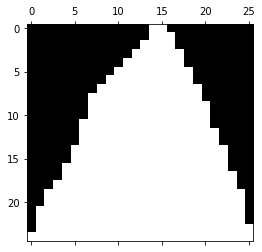

In [12]:
# Get reference region in which to determine lattice vector angles

mask = uv_map.slices['mask'].astype(bool)

fig,ax = plt.subplots()
ax.matshow(mask,cmap='gray')
plt.show()

In [13]:
# Get reference lattice direction

# Find the median of the angle bisecting of the experimental lattice vectors
theta_us = np.zeros(np.sum(mask))
theta_vs = np.zeros(np.sum(mask))
reference_angles = np.zeros(np.sum(mask))
i=0
for Rx in range(R_Nx):
    for Ry in range(R_Ny):
        if mask[Rx,Ry]:
            ux = uv_map.slices['ux'][Rx,Ry]
            uy = uv_map.slices['uy'][Rx,Ry]
            vx = uv_map.slices['vx'][Rx,Ry]
            vy = uv_map.slices['vy'][Rx,Ry]

            theta_us[i] = np.arctan2(uy,ux)
            theta_vs[i] = np.arctan2(vy,vx)
            i += 1
reference_angles = np.mean(np.vstack((theta_us,theta_vs)),axis=0)
reference_theta = np.median(reference_angles)

# Get directions for reference u and v vectors
# For this system, u and v are orthogonal
ref_u_theta = reference_theta + np.pi/4.*np.sign(np.median(theta_us)-reference_theta)
ref_v_theta = reference_theta + np.pi/4.*np.sign(np.median(theta_vs)-reference_theta)

In [14]:
# Get reference lattice
# Values from Padhi, Nanjundaswamy, and Goodenough, J. Electrochemical Society, 1997,
# and from Ohmer et al, Nat. Comm. 2015, who report values (all in Angstroms) of
#      LFP, a: 10.334
#      LFP, b: 6.008
#      LFP, c: 4.693
#      FP, a: 9.821
#      FP, b: 5.792
#      FP, c: 4.788

u_length_A = 10.334
v_length_A = 4.693

u_length_Qpix = 1./(inv_A_per_pixel*u_length_A)
v_length_Qpix = 1./(inv_A_per_pixel*v_length_A)

ux_ref = np.cos(ref_u_theta)*u_length_Qpix
uy_ref = np.sin(ref_u_theta)*u_length_Qpix
vx_ref = np.cos(ref_v_theta)*v_length_Qpix
vy_ref = np.sin(ref_v_theta)*v_length_Qpix

### Calculate strain 

In [15]:
# Calculate strain

strain_map = get_strain_from_reference_uv(ux_ref,uy_ref,vx_ref,vy_ref,uv_map)

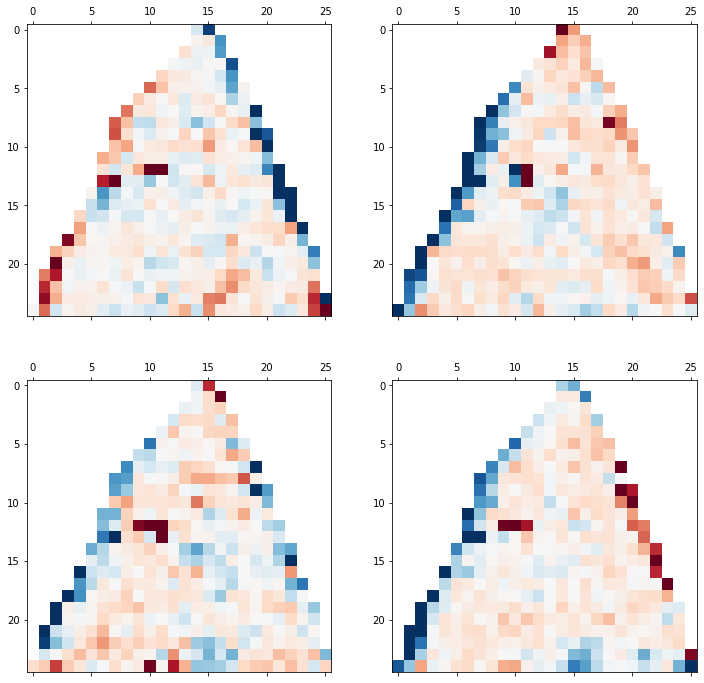

In [16]:
# Preliminary visualization

nstd = 2.5  # Sets display color range

# Set display color scales
e_xx_ave, e_xx_std = np.average(strain_map.slices['e_xx'][mask]),np.std(strain_map.slices['e_xx'][mask])
e_yy_ave, e_yy_std = np.average(strain_map.slices['e_yy'][mask]),np.std(strain_map.slices['e_yy'][mask])
e_xy_ave, e_xy_std = np.average(strain_map.slices['e_xy'][mask]),np.std(strain_map.slices['e_xy'][mask])
theta_ave, theta_std = np.average(strain_map.slices['theta'][mask]),np.std(strain_map.slices['theta'][mask])
e_xx_range = [e_xx_ave-nstd*e_xx_std,e_xx_ave+nstd*e_xx_std]
e_yy_range = [e_yy_ave-nstd*e_yy_std,e_yy_ave+nstd*e_yy_std]
e_xy_range = [e_xy_ave-nstd*e_xy_std,e_xy_ave+nstd*e_xy_std]
theta_range = [theta_ave-nstd*theta_std,theta_ave+nstd*theta_std]

# Plot
fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(12,12))
ax11.matshow(np.ma.array(data=strain_map.slices['e_xx'],mask=strain_map.slices['mask']==0),vmin=e_xx_range[0], vmax=e_xx_range[1], cmap="RdBu_r")
ax12.matshow(np.ma.array(data=strain_map.slices['e_yy'],mask=strain_map.slices['mask']==0),vmin=e_yy_range[0], vmax=e_yy_range[1], cmap="RdBu_r")
ax21.matshow(np.ma.array(data=strain_map.slices['e_xy'],mask=strain_map.slices['mask']==0),vmin=e_xy_range[0], vmax=e_xy_range[1], cmap="RdBu_r")
ax22.matshow(np.ma.array(data=strain_map.slices['theta'],mask=strain_map.slices['mask']==0),vmin=theta_range[0], vmax=theta_range[1], cmap="RdBu_r")
plt.show()

### Rotate strain coordinate system

In [17]:
# Get rotated strain map, with exx direction oriented along u_ref
# Here, we're rotating the strain map such that one of the lattice vectors of the reference lattice is 
# defined as the first principle direction of the strain matrix

strain_map_uvaxes = get_rotated_strain_map(strain_map, ux_ref, uy_ref)

In [18]:
# Get direction of strain map axes in real space for visualization
# Here, we're determining the orientation of the strain matrix coordinate axes, which are defined in
# the diffraction plane, with respect to real space

axes = RQ_axes(RQ_offset_angle)
axes.set_Q_axes(ux_ref,uy_ref)

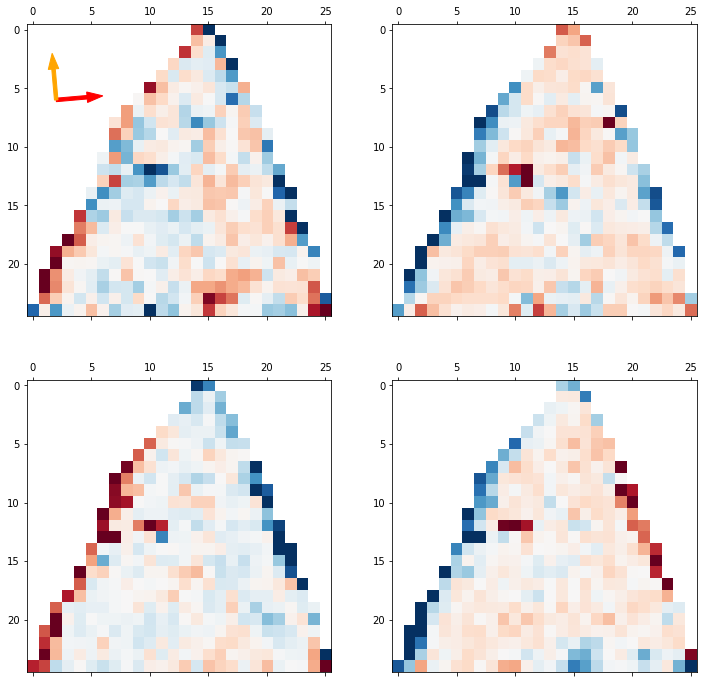

In [19]:
# Preliminary visualization
# Show the x-direction of the strain matrix in red, y-direction in orange

nstd = 2.5  # Sets display color range

show_axes = True
axes_plot = 'e_xx'       # must be 'e_xx', 'e_yy', 'e_xy', or 'theta'
axes_x,axes_y = 6,2
axes_length = 4
axes_width = 0.3

# Set display color scales
e_xx_ave, e_xx_std = np.average(strain_map_uvaxes.slices['e_xx'][mask]),np.std(strain_map_uvaxes.slices['e_xx'][mask])
e_yy_ave, e_yy_std = np.average(strain_map_uvaxes.slices['e_yy'][mask]),np.std(strain_map_uvaxes.slices['e_yy'][mask])
e_xy_ave, e_xy_std = np.average(strain_map_uvaxes.slices['e_xy'][mask]),np.std(strain_map_uvaxes.slices['e_xy'][mask])
theta_ave, theta_std = np.average(strain_map_uvaxes.slices['theta'][mask]),np.std(strain_map_uvaxes.slices['theta'][mask])
e_xx_range = [e_xx_ave-nstd*e_xx_std,e_xx_ave+nstd*e_xx_std]
e_yy_range = [e_yy_ave-nstd*e_yy_std,e_yy_ave+nstd*e_yy_std]
e_xy_range = [e_xy_ave-nstd*e_xy_std,e_xy_ave+nstd*e_xy_std]
theta_range = [theta_ave-nstd*theta_std,theta_ave+nstd*theta_std]

# Plot
fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(12,12))
ax11.matshow(np.ma.array(data=strain_map_uvaxes.slices['e_xx'],mask=strain_map_uvaxes.slices['mask']==0),
             vmin=e_xx_range[0], vmax=e_xx_range[1], cmap="RdBu_r")
ax12.matshow(np.ma.array(data=strain_map_uvaxes.slices['e_yy'],mask=strain_map_uvaxes.slices['mask']==0),
             vmin=e_yy_range[0], vmax=e_yy_range[1], cmap="RdBu_r")
ax21.matshow(np.ma.array(data=strain_map_uvaxes.slices['e_xy'],mask=strain_map_uvaxes.slices['mask']==0),
             vmin=e_xy_range[0], vmax=e_xy_range[1], cmap="RdBu_r")
ax22.matshow(np.ma.array(data=strain_map_uvaxes.slices['theta'],mask=strain_map_uvaxes.slices['mask']==0),
             vmin=theta_range[0], vmax=theta_range[1], cmap="RdBu_r")

if show_axes:
    ax = {'e_xx':ax11,'e_yy':ax12,'e_xy':ax21,'theta':ax22}[axes_plot]
    ax.arrow(axes_y,axes_x,axes_length*axes.Ruy,axes_length*axes.Rux, color='red',width=axes_width,length_includes_head=True)
    ax.arrow(axes_y,axes_x,axes_length*axes.Rvy,axes_length*axes.Rvx, color='orange',width=axes_width,length_includes_head=True)

plt.show()

### Lattice parameters

In [20]:
# Because we're looking here at an orthorhombic crystal projectd along its b-axis, orienting the 1st principle 
# axis of the strain matrix along the crystal a-axis means the second principle axis of the strain matrix is
# along the crystal c-axis

a_lengths_Angs = u_length_A*(1+strain_map_uvaxes.slices['e_xx'])
c_lengths_Angs = v_length_A*(1+strain_map_uvaxes.slices['e_yy'])
a_lengths_Angs[strain_map_uvaxes.slices['mask']==0] = 0
c_lengths_Angs[strain_map_uvaxes.slices['mask']==0] = 0

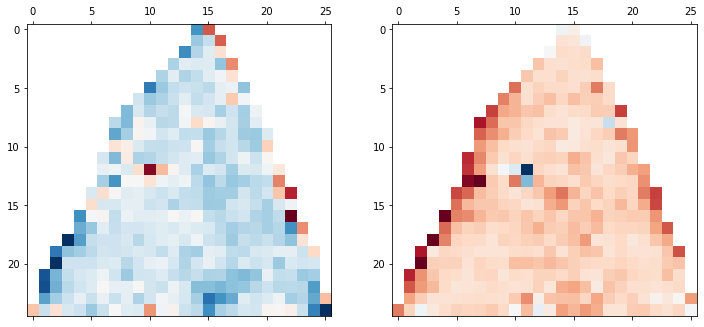

In [21]:
Ang_range = 0.5

fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].matshow(np.ma.array(data=a_lengths_Angs,mask=strain_map_uvaxes.slices['mask']==0),cmap='RdBu',vmin=u_length_A-Ang_range/2,vmax=u_length_A+Ang_range/2)
axs[1].matshow(np.ma.array(data=c_lengths_Angs,mask=strain_map_uvaxes.slices['mask']==0),cmap='RdBu',vmin=v_length_A-Ang_range/2,vmax=v_length_A+Ang_range/2)
plt.show()

### Save

In [22]:
# Reference lattice
coords = [('ux',float),('uy',float),('vx',float),('vy',float)]
reference_lattice = PointList(coordinates=coords)
reference_lattice.add_point((ux_ref,uy_ref,vx_ref,vy_ref))
reference_lattice.name = 'reference_lattice'

# Lattice parameters
slicelabels = ('a_length_Angs','c_length_Angs','mask')
data = np.zeros((R_Nx,R_Ny,3))
data[:,:,0] = a_lengths_Angs
data[:,:,1] = c_lengths_Angs
data[:,:,2] = strain_map_uvaxes.slices['mask']
lattice_parameter_maps = RealSlice(data=data,slicelabels=slicelabels,name='lattice_parameter_maps_Angs')

braggpeaks_indexed.name = 'braggpeaks_corrected_experiment_indexed'
uv_map.name = 'uv_map'
strain_map.name = 'strainmap_unoriented'
strain_map_uvaxes.name = 'strainmap_oriented'

In [23]:
# Append to processing file

dataobjects = [reference_lattice,lattice_parameter_maps,braggpeaks_indexed,strain_map,strain_map_uvaxes]
append(dataobjects, fp_processing)

Opening file /media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/LFP100_P1/processing_sampledata.h5...
Done.
